In [1]:
!nvidia-smi

Thu Nov 18 15:05:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:89:00.0 Off |                  N/A |
| 30%   36C    P8    27W / 350W |    596MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

In [3]:
# !pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:
import os
import pandas as pd
from matplotlib import pyplot as plt
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [5]:
# !unzip dont-stop-until-you-drop.zip

In [6]:
# !ls images/t_images

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('sample_submission.csv')
display(train.head())
display(test.head())

,image_id,class_6
0,1daf45401342ac321c0aa5668f51d004.jpg,5
1,7e15c14f0b25766d0b7378f1d5328e99.jpg,4
2,1dc97053cf67cb8e51c983abb0021083.jpg,4
3,0ceaf686d3b9c1db537fed12b568670d.jpg,1
4,73adbf71f0adcf89c94339f6a6a92b61.jpg,0


,image_id,class_6
0,18c514201d4d375596eaf057d43faa73.jpg,0
1,742cd45c52ee2d9a4745b27e1c5426a3.jpg,0
2,4ebf97acccead03c17d564c6701403ae.jpg,0
3,3a0fe12ec506d9fe99c0e370bce7eeef.jpg,0
4,d3442c050dd87db8b926b449408d793a.jpg,0


In [8]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = 'images/train_images'
TEST_PATH = 'images/test_images'

In [9]:
# ====================================================
# CFG
# ====================================================
model_name = 'swin_large_patch4_window12_384'
class CFG:
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    model_name='swin_large_patch4_window12_384'
    size=384
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=10
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=16
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=6
    target_col='class_6'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=False
    inference=True
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [10]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

if CFG.apex:
    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return f1_score(y_true, y_pred,average='micro')


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [12]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  class_6
0     0          101
      1           98
      2           62
      3           38
      4          121
      5           52
1     0          101
      1           98
      2           62
      3           38
      4          121
      5           52
2     0          101
      1           97
      2           62
      3           39
      4          121
      5           52
3     0          101
      1           98
      2           62
      3           39
      4          120
      5           52
4     0          101
      1           98
      2           62
      3           39
      4          120
      5           52
dtype: int64


In [13]:
folds

,image_id,class_6,fold
0,1daf45401342ac321c0aa5668f51d004.jpg,5,0
1,7e15c14f0b25766d0b7378f1d5328e99.jpg,4,0
2,1dc97053cf67cb8e51c983abb0021083.jpg,4,2
3,0ceaf686d3b9c1db537fed12b568670d.jpg,1,0
4,73adbf71f0adcf89c94339f6a6a92b61.jpg,0,0
...,...,...,...
2355,3cb75d7569544a8be6850893dc939ed6.jpg,4,1
2356,fa14b6703b1eda25b4a851c163a1efc2.jpg,5,1
2357,e58ee6afa09efc6021e8b56a9bda6960.jpg,0,1
2358,94c16216e9674ec1a254c73d56d2ebe1.jpg,2,4


In [14]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['class_6'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

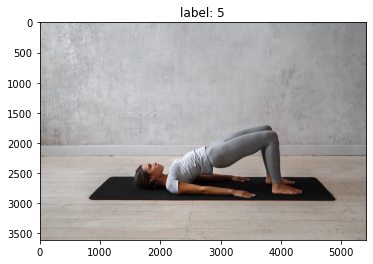

In [15]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

In [16]:
import albumentations
class CutoutV2(albumentations.DualTransform):
    def __init__(
        self,
        num_holes=8,
        max_h_size=8,
        max_w_size=8,
        fill_value=0,
        always_apply=False,
        p=0.5,
    ):
        super(CutoutV2, self).__init__(always_apply, p)
        self.num_holes = num_holes
        self.max_h_size = max_h_size
        self.max_w_size = max_w_size
        self.fill_value = fill_value

    def apply(self, image, fill_value=0, holes=(), **params):
        return albumentations.functional.cutout(image, holes, fill_value)

    def get_params_dependent_on_targets(self, params):
        img = params["image"]
        height, width = img.shape[:2]

        holes = []
        for _n in range(self.num_holes):
            y = random.randint(0, height)
            x = random.randint(0, width)

            y1 = np.clip(y - self.max_h_size // 2, 0, height)
            y2 = np.clip(y1 + self.max_h_size, 0, height)
            x1 = np.clip(x - self.max_w_size // 2, 0, width)
            x2 = np.clip(x1 + self.max_w_size, 0, width)
            holes.append((x1, y1, x2, y2))

        return {"holes": holes}

    @property
    def targets_as_params(self):
        return ["image"]

    def get_transform_init_args_names(self):
        return ("num_holes", "max_h_size", "max_w_size")

In [17]:
# transforms_train = albumentations.Compose([
#     albumentations.Resize(CFG.size, CFG.size),
#     albumentations.HorizontalFlip(p=0.5),
#     albumentations.RandomBrightness(limit=0.2, p=0.75),
#     albumentations.RandomContrast(limit=0.2, p=0.75),

#     albumentations.OneOf([
#         albumentations.OpticalDistortion(distort_limit=1.),
#         albumentations.GridDistortion(num_steps=5, distort_limit=1.),
#     ], p=0.75),

#     albumentations.HueSaturationValue(hue_shift_limit=40, sat_shift_limit=40, val_shift_limit=0, p=0.75),
#     albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=5, border_mode=0, p=0.75),
#     CutoutV2(max_h_size=int(CFG.size * 0.2), max_w_size=int(CFG.size * 0.2), num_holes=1, p=0.75),
# ])
# transforms_val = albumentations.Compose([
#     albumentations.Resize(image_size, image_size),
# ])

In [18]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            Resize(CFG.size, CFG.size),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.RandomBrightness(limit=0.2, p=0.75),
            albumentations.RandomContrast(limit=0.2, p=0.75),
            HorizontalFlip(p=0.5),
            albumentations.HueSaturationValue(hue_shift_limit=40, sat_shift_limit=40, val_shift_limit=0, p=0.75),
            albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=5, border_mode=0, p=0.75),
            CutoutV2(max_h_size=int(CFG.size * 0.2), max_w_size=int(CFG.size * 0.2), num_holes=1, p=0.75),# VerticalFlip(p=0.5),
            # ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

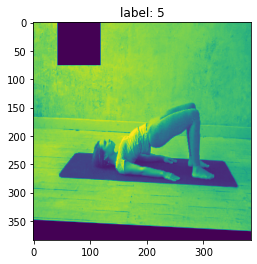

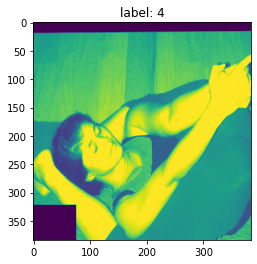

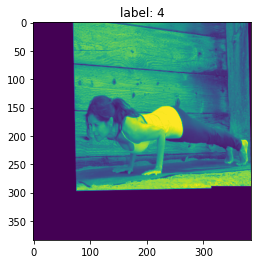

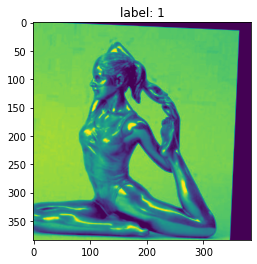

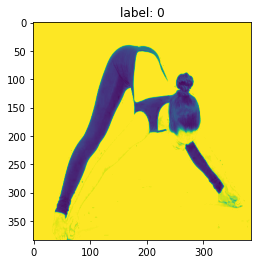

In [19]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show()

In [20]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained,num_classes=6)

    def forward(self, x):
        x = self.model(x)
        return x

In [21]:
model = CustomResNext(model_name=CFG.model_name, pretrained=True)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    with torch.no_grad():
        output = model(image)
    print(output)
    break

tensor([[-0.2015,  0.3170, -0.0558, -0.1971,  0.2168,  0.0746],
        [-0.5544, -0.5889, -0.7396,  0.1273, -0.4947,  0.7577],
        [-0.2553,  0.0814, -0.0563, -0.2245,  0.1714,  0.0701],
        [-0.5538, -0.2364,  0.2850,  0.4828,  0.1008,  0.4569]])


In [22]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model,model2, states,states2, test_loader, device):
    model.to(device)
    model2.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        for state in states2:
            model2.load_state_dict(state['model'])
            model2.eval()
            with torch.no_grad():
                y_preds = model2(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [23]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    # valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    # valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [24]:
# ====================================================
# main
# ====================================================
def main():
    if CFG.inference:
        # inference
        #model = CustomResNext('swin_base_patch4_window12_384', pretrained=False)
        model = timm.create_model(model_name, pretrained=True,num_classes=6)
        model2 = timm.create_model('swin_base_patch4_window12_384', pretrained=True,num_classes=6)
        states = [torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in [0,2,3,4]]
        states2 = [torch.load(OUTPUT_DIR+f'resnext50_32x4d_fold{fold}_best.pth') for fold in [2,3]]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                                 num_workers=CFG.num_workers, pin_memory=True)
        predictions = inference(model,model2, states,states2, test_loader, device)
        test['pred0'] = predictions[:,0]
        test['pred1'] = predictions[:,1]
        test['pred2'] = predictions[:,2]
        test['pred3'] = predictions[:,3]
        test['pred4'] = predictions[:,4]
        test['pred5'] = predictions[:,5]
        # submission
        test['class_6'] = predictions.argmax(1)
        test[['image_id', 'class_6']].to_csv('submissionswinl_all.csv', index=False)
        test.to_csv('submission_swinl_prob_all.csv', index=False)

In [25]:
if __name__ == '__main__':
    main()

  0%|          | 0/48 [00:00<?, ?it/s]

In [26]:
!nvidia-smi

Thu Nov 18 15:08:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:89:00.0 Off |                  N/A |
| 37%   68C    P2   212W / 350W |  11413MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
# import torch

In [28]:
# torch.__version__

In [29]:
# !pip install torch==1.7 torchvision